In [64]:
import databento as db
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [65]:
client = db.Historical("db-QNue9tcjaXcJGDXRTMnSPAvrF8V7c")



In [66]:
datasets = client.metadata.list_datasets()
print(datasets)

['ARCX.PILLAR', 'DBEQ.BASIC', 'EPRL.DOM', 'EQUS.SUMMARY', 'GLBX.MDP3', 'IEXG.TOPS', 'IFEU.IMPACT', 'NDEX.IMPACT', 'OPRA.PILLAR', 'XASE.PILLAR', 'XBOS.ITCH', 'XCHI.PILLAR', 'XCIS.TRADESBBO', 'XNAS.BASIC', 'XNAS.ITCH', 'XNYS.PILLAR', 'XPSX.ITCH']


In [67]:
#start_date a week from today
start_date = datetime.now() - timedelta(days=7)
#end date yesterday
end_date = datetime.now() - timedelta(days=1)
symbols = ["AAPL"]

df = client.timeseries.get_range(
    dataset="XNAS.ITCH",
    schema="mbp-10",
    symbols=symbols,
    start=start_date,
    end=end_date,
    limit=10_000,
).to_df()

df.head()

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
ts_recv,,,,,,,,,,,,,,,,,,,,,
2025-01-08 09:49:06.125851151+00:00,2025-01-08 09:49:06.125684906+00:00,10,2,38,C,B,1,242.51,200,130,...,20,1,1,242.0,244.10,455,100,3,1,AAPL
2025-01-08 09:49:06.125862964+00:00,2025-01-08 09:49:06.125697070+00:00,10,2,38,A,B,2,242.49,200,130,...,20,1,1,242.1,244.10,3,100,1,1,AAPL
2025-01-08 09:49:06.189207590+00:00,2025-01-08 09:49:06.189040782+00:00,10,2,38,A,A,1,242.71,400,130,...,20,1,1,242.1,244.10,3,100,1,1,AAPL
2025-01-08 09:49:06.202299550+00:00,2025-01-08 09:49:06.202133871+00:00,10,2,38,C,A,3,242.80,28,130,...,100,1,1,242.1,244.73,3,40,1,1,AAPL
2025-01-08 09:49:06.202331048+00:00,2025-01-08 09:49:06.202164541+00:00,10,2,38,A,A,3,242.79,30,130,...,20,1,1,242.1,244.10,3,100,1,1,AAPL


In [68]:
#cleaning the data for plotting
def clean_data(df):

  #reset index
  df.reset_index(inplace=True)
  #drop columns
  df.drop(columns=['ts_recv','ts_event', 'rtype', 'instrument_id', 'symbol', 'publisher_id', 'flags', 'sequence'], inplace=True)

  # Filter and prepare data for visualization
  # Extract columns related to bid and ask prices and sizes
  bid_data = df.filter(regex='bid_px_|bid_sz_')
  ask_data = df.filter(regex='ask_px_|ask_sz_')

  # Melt the bid and ask data into long format for easier aggregation and visualization
  bid_prices = bid_data.filter(regex='bid_px_').melt(var_name='level', value_name='price')
  bid_sizes = bid_data.filter(regex='bid_sz_').melt(var_name='level', value_name='size')

  ask_prices = ask_data.filter(regex='ask_px_').melt(var_name='level', value_name='price')
  ask_sizes = ask_data.filter(regex='ask_sz_').melt(var_name='level', value_name='size')

  # Combine price and size data for bids and asks
  bid_prices['type'] = 'bid'
  ask_prices['type'] = 'ask'
  bid_prices['size'] = bid_sizes['size']
  ask_prices['size'] = ask_sizes['size']

  # Concatenate bids and asks for a unified dataset
  order_book_cleaned = pd.concat([bid_prices, ask_prices], ignore_index=True)

  # Drop rows with missing or invalid values
  order_book_cleaned = order_book_cleaned.dropna()
  order_book_cleaned['price'] = pd.to_numeric(order_book_cleaned['price'], errors='coerce')
  order_book_cleaned['size'] = pd.to_numeric(order_book_cleaned['size'], errors='coerce')
  order_book_cleaned = order_book_cleaned.dropna()

  # Save the cleaned data if needed
  order_book_cleaned.to_csv('cleaned_order_book.csv', index=False)

  cleaned_data = order_book_cleaned

  return cleaned_data

In [69]:
cleaned_data = clean_data(df)


In [74]:
cleaned_data.tail()
cleaned_data.head()

,level,price,type,size
0,bid_px_00,242.55,bid,2
1,bid_px_00,242.55,bid,2
2,bid_px_00,242.55,bid,2
3,bid_px_00,242.55,bid,2
4,bid_px_00,242.55,bid,2


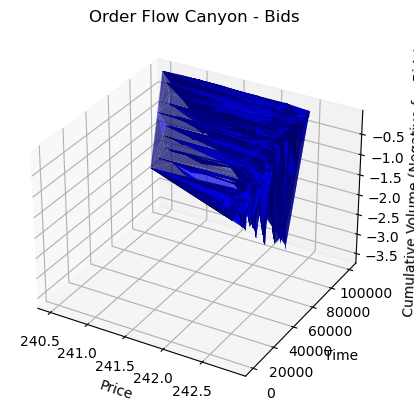

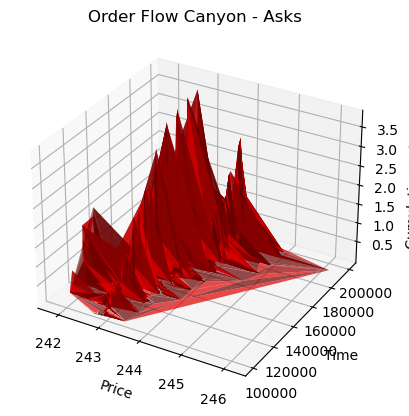

In [85]:
order_book_cleaned = pd.read_csv('cleaned_order_book.csv')

# Separate bids and asks
bids = order_book_cleaned[order_book_cleaned['type'] == 'bid'].copy()
asks = order_book_cleaned[order_book_cleaned['type'] == 'ask'].copy()

# Calculate cumulative volumes for bids and asks
bids['cumulative_volume'] = bids.groupby('price')['size'].cumsum()
asks['cumulative_volume'] = asks.groupby('price')['size'].cumsum()

# Create time axis (or use actual timestamps if available)
bids.loc[:, 'time'] = bids.index  # Assuming time is represented by index
asks.loc[:, 'time'] = asks.index  # Assuming time is represented by index

# Plot bids in 3D
fig_bids = plt.figure()
ax_bids = fig_bids.add_subplot(111, projection='3d')
ax_bids.plot_trisurf(
    bids['price'], bids['time'], -bids['cumulative_volume'], color='blue', alpha=0.7
)
ax_bids.set_title('Order Flow Canyon - Bids')
ax_bids.set_xlabel('Price')
ax_bids.set_ylabel('Time')
ax_bids.set_zlabel('Cumulative Volume (Negative for Bids)')

# Plot asks in 3D
fig_asks = plt.figure()
ax_asks = fig_asks.add_subplot(111, projection='3d')
ax_asks.plot_trisurf(
    asks['price'], asks['time'], asks['cumulative_volume'], color='red', alpha=0.7
)
ax_asks.set_title('Order Flow Canyon - Asks')
ax_asks.set_xlabel('Price')
ax_asks.set_ylabel('Time')
ax_asks.set_zlabel('Cumulative Volume')

# Show the plots
plt.show()